In [2]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import pickle as pkl

# load tokenized dataset

In [3]:
dataset_dir_path = '../../data/processed/tokenized_data/'
with open(dataset_dir_path + 'train_data.pkl', 'rb') as f:
    tokenized_train_data = pkl.load(f)

with open(dataset_dir_path + 'valid_data.pkl', 'rb') as f:
    tokenized_valid_data = pkl.load(f)

In [4]:
print(f'Input(de) {tokenized_train_data[0][0]}')
print(f'Output(en) {tokenized_train_data[0][1]}')

Input(de) tensor([   2,   21,   85,  256,   31,   86,   22,   93,    7,   16,  114, 5645,
        3245,    3])
Output(en) tensor([   2,   19,   25,   15, 1197,  817,   17,   58,   84,  332, 1319,    3])


# load vocab

In [5]:
vocab_dir_path = '../../data/processed/vocab/'

with open(vocab_dir_path + 'token2idx_de.pkl', 'rb') as f:
    token2idx_de= pkl.load(f)
with open(vocab_dir_path + 'token2idx_en.pkl', 'rb') as f:
    token2idx_en = pkl.load(f)
with open(vocab_dir_path + 'idx2token_de.pkl', 'rb') as f:
    idx2token_de = pkl.load(f)
with open(vocab_dir_path + 'idx2token_en.pkl', 'rb') as f:
    idx2token_en = pkl.load(f)

# making the batch

In [6]:
batch_size = 128
PAD_INDEX = token2idx_de['<pad>']
START_INDEX = token2idx_en['<start>']
END_INDEX = token2idx_en['<end>']

In [7]:
def generate_batch(data_batch):
    batch_src = []
    batch_tgt = []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
    
    batch_src = pad_sequence(batch_src, padding_value=PAD_INDEX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_INDEX)

    return batch_src, batch_tgt

In [8]:
train_iter = DataLoader(tokenized_train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(tokenized_valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [9]:
# show train_iter
# each column is a text
list(train_iter)[0]

(tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [   5,   14,   76,  ...,    5,   14,    5],
         [1094,   17,   77,  ..., 6631,   17, 3180],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [   6,    6,   83,  ...,    6,    6,    6],
         [ 563,   16,   42,  ...,  798,   16, 1290],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]))

# Model

In [10]:
import math
import torch
import torch.nn as nn
from torch import Tensor

## token embedding

In [11]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        # nn.Embedding is a simple lookup table.
        # if token index is set, it will return the corresponding embedding vector.
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding_size = embedding_size
    
    def forward(self, tokens: Tensor):
        # the reason for this multiply is to align the range of the values
        # It is to make the positional encoding relatively smaller. 
        # This means the original meaning in the embedding vector won’t be lost 
        # when we add them together.
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)

In [12]:
token_embedding = TokenEmbedding(len(token2idx_de), 512)

In [13]:
len(token2idx_de)

19620

In [14]:
for src, tgt in train_iter:
    print(f'bached data shape : {src.shape[0]} words, {src.shape[1]} sentences')
    print(f'bached data {src}')
    res = token_embedding.forward(src)
    print(f'result shape : {res.shape}')
    print(f'result {res}')
    print(f'sqrt : {math.sqrt(token_embedding.embedding_size)}')
    break

bached data shape : 26 words, 128 sentences
bached data tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 830,    5,   87,  ...,  271,   14, 7218],
        [  12,   12,   35,  ...,   31,   17,   59],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
result shape : torch.Size([26, 128, 512])
result tensor([[[-14.0476, -32.1047,  14.2814,  ...,  47.3367,  -1.9208,  12.9211],
         [-14.0476, -32.1047,  14.2814,  ...,  47.3367,  -1.9208,  12.9211],
         [-14.0476, -32.1047,  14.2814,  ...,  47.3367,  -1.9208,  12.9211],
         ...,
         [-14.0476, -32.1047,  14.2814,  ...,  47.3367,  -1.9208,  12.9211],
         [-14.0476, -32.1047,  14.2814,  ...,  47.3367,  -1.9208,  12.9211],
         [-14.0476, -32.1047,  14.2814,  ...,  47.3367,  -1.9208,  12.9211]],

        [[ -1.5454, -11.5617, -12.6570,  ...,  11.8376,  17.6872,   8.2390],
         [  7.

## positional encoging

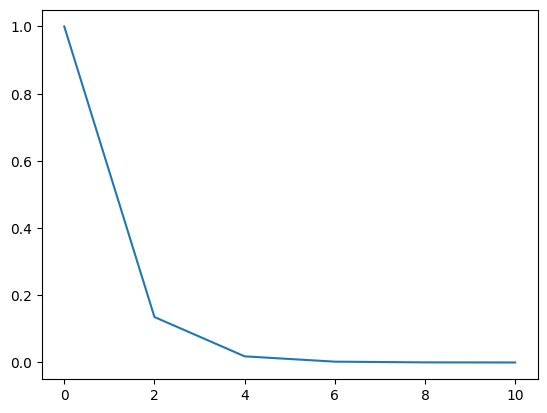

In [15]:
inx = torch.arange(0, 12, 2)
outx = torch.exp(-inx)
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(inx, outx)
plt.show()

In [16]:
maxlen = 5
embedding_size = 6
positional_encoding = torch.zeros(maxlen, embedding_size)
for i, v in enumerate(positional_encoding):
    positional_encoding[i, 0] = i

den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
print(f'den : {den.shape}')
print(f'den : {den}')

den : torch.Size([3])
den : tensor([1.0000, 0.0464, 0.0022])


In [17]:
pos = torch.arange(0, maxlen).reshape(maxlen, 1)
print(f'pos : {pos.shape}')
print(f'pos : {pos}')

pos : torch.Size([5, 1])
pos : tensor([[0],
        [1],
        [2],
        [3],
        [4]])


In [18]:
cross = pos * den
print(f'cross : {cross.shape}')
print(f'cross : {cross}')

cross : torch.Size([5, 3])
cross : tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.6416e-02, 2.1544e-03],
        [2.0000e+00, 9.2832e-02, 4.3089e-03],
        [3.0000e+00, 1.3925e-01, 6.4633e-03],
        [4.0000e+00, 1.8566e-01, 8.6177e-03]])


In [19]:
positional_encoding = torch.zeros((maxlen, embedding_size))
print(f'positional_encoding : {positional_encoding.shape}')
positional_encoding[:, 0::2] = torch.sin(cross)
print(positional_encoding[:, 0::2])

positional_encoding : torch.Size([5, 6])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086]])


In [20]:

positional_encoding[:, 1::2] = torch.cos(cross)
print(positional_encoding[:, 1::2])

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000]])


In [21]:
print(f'before : {positional_encoding.shape}')
positional_encoding = positional_encoding.unsqueeze(-2)
print(f'after : {positional_encoding.shape}')


before : torch.Size([5, 6])
after : torch.Size([5, 1, 6])


In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den) # extract even element (start:stop:step)
        embedding_pos[:, 1::2] = torch.cos(pos * den) # extract odd element (start:stop:step)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos) # positional encoding is not updated by learning

    def forward(self, token_embedding: Tensor):
        print(f'token_embedding : {token_embedding.shape}')
        print(f'positional_encoding : {self.embedding_pos.shape}') # self.embedding_pos is defined by self.register_fuffer.
        # self.embedding_pos is not updated by learning
        print(f'positional_encoding : {self.embedding_pos[:token_embedding.size(0), :].shape}')
        return self.dropout(token_embedding + self.embedding_pos[:token_embedding.size(0), :])

In [23]:
positional_encoding = PositionalEncoding(512, 0.1)
positional_encoding.forward(token_embedding.forward(src))

token_embedding : torch.Size([26, 128, 512])
positional_encoding : torch.Size([5000, 1, 512])
positional_encoding : torch.Size([26, 1, 512])


tensor([[[-15.6085, -34.5608,  15.8683,  ...,  53.7074,  -2.1342,  15.4679],
         [-15.6085,  -0.0000,  15.8683,  ...,  53.7074,  -2.1342,  15.4679],
         [-15.6085, -34.5608,  15.8683,  ...,  53.7074,  -2.1342,  15.4679],
         ...,
         [-15.6085,  -0.0000,  15.8683,  ...,  53.7074,  -2.1342,  15.4679],
         [-15.6085, -34.5608,  15.8683,  ...,  53.7074,  -2.1342,  15.4679],
         [-15.6085, -34.5608,  15.8683,  ...,  53.7074,  -2.1342,  15.4679]],

        [[ -0.7822, -12.2461, -13.1501,  ...,   0.0000,  19.6526,  10.2656],
         [  9.4058,  -8.5545,   1.6702,  ...,   0.0000,  21.6002, -13.9696],
         [-20.7441, -11.0679, -10.4386,  ..., -15.4433,   0.0000,  19.5080],
         ...,
         [ -0.3586,  -0.5184, -19.1308,  ...,   6.1943,  -0.0000,  14.4633],
         [ 24.3115, -13.3931,   0.0000,  ...,  -5.7169,  -0.6486,  35.9014],
         [-12.7980,   1.2230, -23.6892,  ...,  22.3804,  10.0793, -20.0188]],

        [[-22.7426,  -8.6425,  16.8391,  ...

In [24]:
positional_encoding.embedding_pos[:src.size(0), :].shape

torch.Size([26, 1, 512])

In [25]:
positional_encoding.embedding_pos.shape

torch.Size([5000, 1, 512])